In [1]:
# -*- coding: utf8 -*-
import re
import sys
import argparse
import pymorphy2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cross_validation import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from xgboost.sklearn import XGBClassifier
from sklearn import linear_model, metrics
from scipy import interp

%matplotlib inline

data_file = "data/train.txt"
vocab_file = "data/vocab.txt"
stopwords_file = "data/stopwords.txt"

In [2]:
vocab = []
with open(vocab_file, "r") as f:
    s = f.read()
    vocab = s.split(',')

stopwords = []
with open(stopwords_file, "r") as f:
    s = f.read()
    stopwords = s.split(',')

In [3]:
morph = pymorphy2.MorphAnalyzer()

def f(word):
    return morph.parse(word)[0].normal_form

def process_table(table):
    data = table[1].str.split(',', 2).apply(pd.Series, 1)
    data = data[data[2] != ""]
    data[2] = data[2].apply(lambda x: str(x)[9:-3])
    data.columns = ["id", "label", "text"]
    data['label'] = data['label'].apply(lambda x: '1' if x == '3' or x == '4' else '0')
    return data

def process_text(text):
    sample = re.split('\W+', re.sub('\W(Н|н)(е|Е) ', ' не', text))
    l = [f(x) for x in sample if f(x) not in stopwords and not re.match("[0-9]+", x)]
    text = ' '.join(l)
    return text

def process(path):
    data = pd.read_csv(path, delimiter='autoru-', header = None, quoting=3, engine='python')
    data = process_table(data)
    data['text'] = data['text'].apply(lambda x: process_text(x))
    data.to_csv(path + ".proc.txt", sep='\t', encoding='utf-8')
    return data


In [4]:
def read_chunk(f, delimiter):
    buf = ""
    while True:
        while delimiter in buf:
            pos = buf.index(delimiter)
            yield buf[:pos]
            buf = buf[pos + len(delimiter):]
        chunk = f.read(2048)
        if not chunk:
            yield buf
            break
        buf += chunk


def get_data(input, flag):
    data, labels = [], []
    if flag:
        train_data = process(input)
        data, labels = train_data['text'], train_data['labels']
    else:
        with open(input) as f:
            gen = read_chunk(f, "\n")
            for i in range(80000):
                s = next(gen).split('\t')
                data.append(s[-1])
                labels.append(s[-2])
    return np.array(data), np.array(labels).astype(int)

data, labels = get_data(data_file, False)
inv_labels = np.logical_not(labels)

In [5]:
def get_word_frequencies(some_data, out_file):
    word_freq = {}
    vectorizer = CountVectorizer(vocabulary=vocab)
    data_features = vectorizer.fit_transform(some_data).toarray()
    words = vectorizer.get_feature_names()
    frequencies = np.sum(data_features, axis=0)
    #with open(out_file, "w+") as f:
    for i, (fr, word) in enumerate(sorted(zip(frequencies, words), reverse=True)):
        if word not in stopwords:
            #f.write(str(fr) + ' ' + word + '\n')
            word_freq[word] = i + 1
    return word_freq

good = get_word_frequencies(data[labels], "data/clean_good_vocab.txt")
bad = get_word_frequencies(data[inv_labels], "data/clean_bad_vocab.txt")

def preprocess(data):
    for i in range(len(data)):
        for j in range(len(data[0])):
            if data[i][j] != 0:
                val = (bad[vocab[j]] if vocab[j] in bad else len(bad) / (good[vocab[j]] if vocab[j] in good else len(good)))
                data[i][j] = data[i][j] * val
            if not np.isfinite(data[i][j]):
                print(vocab[j])
    return data

TP: 171, TN: 15178, FP: 107, FN: 544
Precision Score : 0.615108
Recall Score : 0.239161
Accuracy : 0.9593
TP: 129, TN: 15180, FP: 105, FN: 586
Precision Score : 0.551282
Recall Score : 0.180420
Accuracy : 0.9568
TP: 136, TN: 15223, FP: 62, FN: 579
Precision Score : 0.686869
Recall Score : 0.190210
Accuracy : 0.9599
TP: 178, TN: 15196, FP: 89, FN: 537
Precision Score : 0.666667
Recall Score : 0.248951
Accuracy : 0.9609
TP: 226, TN: 15221, FP: 64, FN: 489
Precision Score : 0.779310
Recall Score : 0.316084
Accuracy : 0.9654


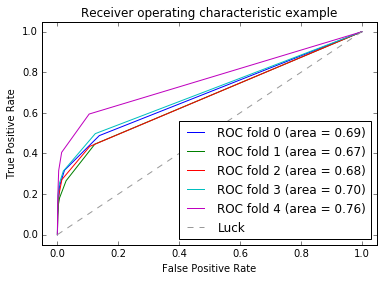

In [10]:
def test(with_probas=True):
    cv = StratifiedKFold(labels, n_folds=5)

    for i, (train, test) in enumerate(cv):
        vectorizer = CountVectorizer(vocabulary=vocab)
        features = vectorizer.fit_transform(data[train])
        
        # preprocessing with tfidf
        transformer = TfidfTransformer()
        #tfidf_features = transformer.fit(features).transform(features)
        #X = tfidf_features.toarray()
        
        # preprocessing with bad/good ranking
        #X = preprocess(features.toarray())
        
        X = features.toarray()
        y = labels[train]

        X, X1, y, y1 = train_test_split(X, y, test_size=0.5)
        clf1 = RandomForestClassifier(n_estimators=40)
        clf2 = KNeighborsClassifier()
        clf = RandomForestClassifier(n_estimators=40)
        enc = OneHotEncoder()
        clf1.fit(X, y)
        enc.fit(clf1.apply(X))
        clf2.fit(enc.transform(clf1.apply(X1)), y1)
        

        X_test = vectorizer.transform(data[test])
        #X_test = preprocess(X_test.toarray())
        y_test = labels[test]
        
        res = clf2.predict(enc.transform(clf1.apply(X_test)))  
        #res = clf.predict(X_test)
        
        if with_probas:
            res_p = clf2.predict_proba(enc.transform(clf1.apply(X_test)))
            #res_p = clf.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, res_p[:,1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

        check = zip(y_test, res)
        tp, tn, fp, fn = 0, 0, 0, 0
        for value, prediction in check:
            if (prediction and value):
                tp += 1
            if (prediction and not value):
                fp += 1
            if (not prediction and value):
                fn += 1
            if (not prediction and not value):
                tn += 1
        print ('TP: {0}, TN: {1}, FP: {2}, FN: {3}'.format(tp, tn, fp, fn))
        print ("Precision Score : %f" % metrics.precision_score(y_test, res))
        print ("Recall Score : %f" % metrics.recall_score(y_test, res))
        print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, res))

    if with_probas:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

test()